In [1]:
import math

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

##### 1. **Bollinger Bands (布林带)**
用于描述金融工具或商品的价格和波动性随时间的变化。波段由一个中间波段（作为滚动平均值）和两个位于标准差距离处的外波段组成。此设置有助于确定价格相对来说是高还是低。它们对于发现供应过剩和供应不足的时期特别有用，这可能预示着潜在的买入或卖出机会。
- **中轨 (Middle Band)**:
  $$
  \text{Middle Band} = \text{rolling\_mean} = \frac{1}{n} \sum_{i=t-n+1}^{t} \text{data}_i
  $$
  其中，$ n $ 是窗口大小，$ \text{data}_i $ 是第 $ i $ 个数据点。

- **标准差 (Standard Deviation)**:
  $$
  \text{rolling\_std} = \sqrt{\frac{1}{n} \sum_{i=t-n+1}^{t} (\text{data}_i - \text{rolling\_mean})^2}
  $$

- **上轨 (Upper Band)**:
  $$
  \text{Upper Band} = \text{rolling\_mean} + k \cdot \text{rolling\_std}
  $$
  其中，\( k \) 是标准差倍数（通常为 2）。

- **下轨 (Lower Band)**:
  $$
  \text{Lower Band} = \text{rolling\_mean} - k \cdot \text{rolling\_std}
  $$
##### 2. **Relative Strength Index (RSI, 相对强弱指数)**
衡量价格变动速度和变化的动量震荡指标。RSI 在 0 和 100 之间振荡。根据 Wilder 的说法，传统上，RSI 在 70 以上被视为超买，在低于 30 时被视为超卖。该指标帮助交易者根据资产价格变动的内部强度识别潜在的反转点。

- **价格变化 (Price Change)**:
  $
  \Delta_t = \text{data}_t - \text{data}_{t-1}
  $

- **涨幅 (Gain)**:
  $
  G_t = \max(\Delta_t, 0)
  $

- **跌幅 (Loss)**:
  $
  L_t = \max(-\Delta_t, 0)
  $

- **平均涨幅 (Average Gain)**:
  $
  \text{avg\_gain}_t = \frac{1}{n} \sum_{i=t-n+1}^{t} G_i
  $

- **平均跌幅 (Average Loss)**:
  $
  \text{avg\_loss}_t = \frac{1}{n} \sum_{i=t-n+1}^{t} L_i
  $

- **相对强弱 (Relative Strength, RS)**:
  $
  \text{RS} = \frac{\text{avg\_gain}}{\text{avg\_loss}}
 $

- **RSI**:
  $
  \text{RSI} = 100 - \frac{100}{1 + \text{RS}}
  $
##### 3. **Rate of Change (ROC, 变化率)**
是一个动量振荡器，它衡量当前价格与一定周期前的价格之间的百分比变化。ROC 通常用于检测背离，当资产价格与技术指标相反时，就会出现背离，并可能表明资产的价格将发生反转。
$$
\text{ROC}_t = \frac{\text{close}_t - \text{close}_{t-n}}{\text{close}_{t-n}} \times 100
$$

其中，$ n $ 是周期数，$ \text{close}_t $ 是第 $ t $ 个收盘价。



In [2]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def calculate_roc(close, periods=14):  
    return close.pct_change(periods=periods, fill_method=None) * 100  

In [3]:
# 大型科技公司MAMAA: Meta, Apple, Microsoft, Amazon, Alphabet(Google, YouTube, Waymo, etc.)
tickers = ['META', 'AAPL', 'MSFT', 'AMZN', 'GOOG']

In [4]:
import os 
# 提取Data文件夹中的所有csv文件名
folder_path = 'Data/CSI 300'

# 文件名的集合, 不可重复
csv_files = set()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_files.add(file_name.replace('.csv',''))
print(csv_files)

{'weekly', 'daily', 'monthly'}


##### 蜡烛图

In [5]:
stats = {}
ticker = 'daily' 

data = pd.read_csv('Data/CSI 300/' + ticker + '.csv')
# 提取参数
openPrice = data['OpenPrice']
highPrice = data['HighPrice']
lowPrice = data['LowPrice']
closePrice = data['ClosePrice']
volume = data['Volume']
changeRatio = data['ChangeRatio']
data['Date'] = pd.to_datetime(data['CloseDate'])

# 计算技术指标
upperBollBands, lowerBollBands = calculate_bollinger_bands(closePrice, window=14, num_of_std=2)
bollWidth = upperBollBands - lowerBollBands
rsi = calculate_rsi(closePrice, window=14)
roc = calculate_roc(closePrice, periods=10)

dataFrame = pd.DataFrame({
    # 'OpenPrice': openPrice,
    # 'HighPrice': highPrice,
    # 'LowPrice': lowPrice,
    'ClosePrice': closePrice,
    'Volume': volume,
    'ChangeRatio': changeRatio,
    'BollWidth': bollWidth,
    'RSI': rsi,
    'ROC': roc,
    'Date': data['Date']
})
# 设置日期为索引
dataFrame.set_index('Date', inplace=True)
preDataFrame = dataFrame.copy()
preDataFrame.head()
#dataFrame.head()



,ClosePrice,Volume,ChangeRatio,BollWidth,RSI,ROC
Date,,,,,,
2021-03-04,3503.492,3.936161e+10,-0.020524,NaN,NaN,NaN
2021-03-05,3501.987,3.564092e+10,-0.000430,NaN,0.0,NaN
2021-03-08,3421.414,3.870480e+10,-0.023008,NaN,0.0,NaN
2021-03-09,3359.292,4.076525e+10,-0.018157,NaN,0.0,NaN
2021-03-10,3357.737,2.997492e+10,-0.000463,NaN,0.0,NaN


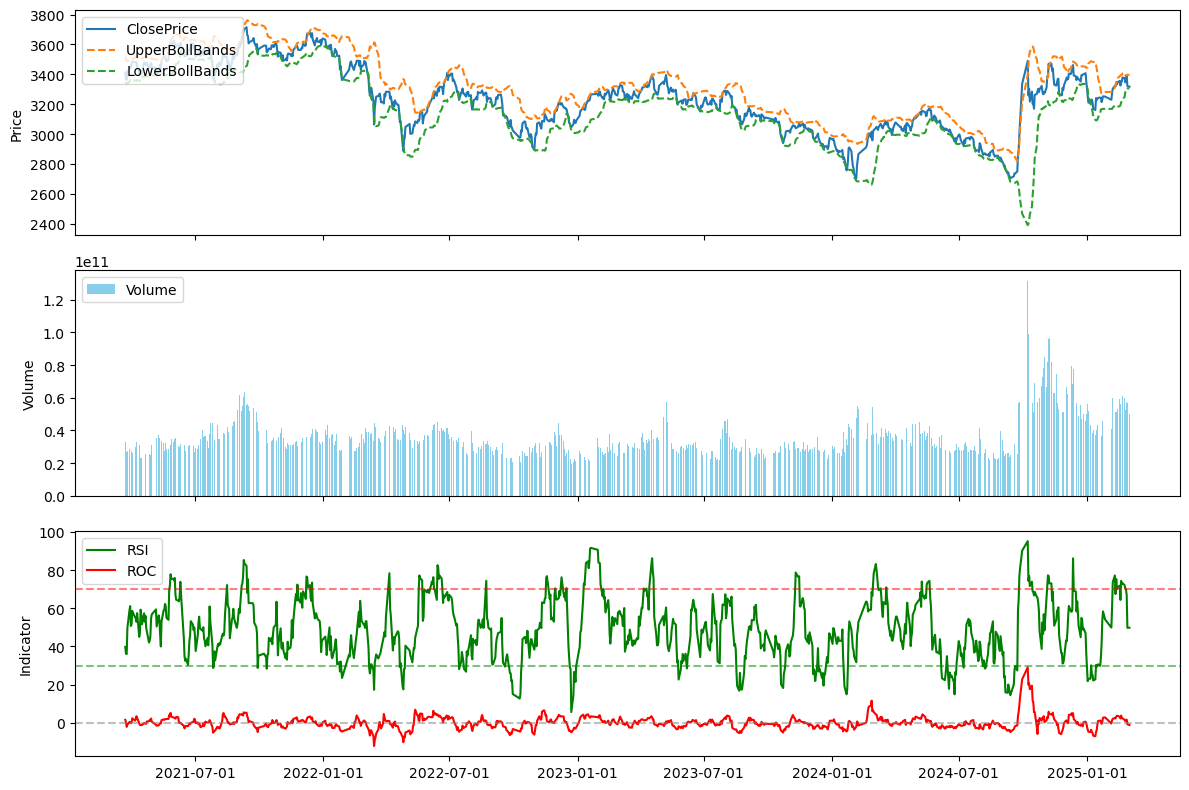

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dataPreview = pd.DataFrame({
    'ClosePrice': closePrice,
    'Volume': volume,
    'UpperBollBands': upperBollBands,
    'LowerBollBands': lowerBollBands, 
    'RSI': rsi,
    'ROC': roc,
    'Date': data['Date']
})
# 设置日期为索引
dataPreview.set_index('Date', inplace=True)
dataPreview.dropna(inplace=True)

# 创建子图  
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)  

# 绘制收盘价和布林带  
ax1.plot(dataPreview.index, dataPreview['ClosePrice'], label='ClosePrice')  
ax1.plot(dataPreview.index, dataPreview['UpperBollBands'], label='UpperBollBands', linestyle='--')  
#ax1.plot(dataPreview.index, dataPreview['布林带中轨'], label='布林带中轨', linestyle='--')  
ax1.plot(dataPreview.index, dataPreview['LowerBollBands'], label='LowerBollBands', linestyle='--')  
ax1.set_ylabel('Price')  
ax1.legend(loc='upper left')  
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动调整日期刻度  
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 设置日期格式  
ax1.tick_params(axis='x', rotation=45) # Rotate date labels  

# 绘制交易量 (柱状图)  
ax2.bar(dataPreview.index, dataPreview['Volume'], label='Volume', color='skyblue')  
ax2.set_ylabel('Volume')  
ax2.legend(loc='upper left')  

# 绘制 RSI 和 ROC  
ax3.plot(dataPreview.index, dataPreview['RSI'], label='RSI', color='green')  
ax3.plot(dataPreview.index, dataPreview['ROC'], label='ROC', color='red')  
ax3.set_ylabel('Indicator')  
ax3.legend(loc='upper left')  
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5) # RSI 超买线  
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5) # RSI 超卖线  
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5) # ROC 零线

# 自动调整子图布局  
fig.tight_layout()  

# 显示图形  
plt.show() 

In [7]:
# 标准化数据, 剔除所有数据包含NaN的行
dataFrame.dropna(inplace=True)
MEAN = dataFrame.mean()
STD = dataFrame.std()

for column in MEAN.index:
    stats[f'{column}_mean'] = MEAN[column]
    stats[f'{column}_std'] = STD[column]

dataFrame = (dataFrame - MEAN) / STD
dataFrame.dropna(inplace=True)
dataFrame.head(500)

,ClosePrice,Volume,ChangeRatio,BollWidth,RSI,ROC
Date,,,,,,
2021-03-23,0.793169,-0.262753,-0.920335,0.029235,-0.600018,0.471924
2021-03-24,0.592072,-0.338901,-1.292648,-0.029030,-0.826559,0.077028
2021-03-25,0.576377,-0.734621,-0.103249,-0.161587,-0.835631,-0.667994
2021-03-26,0.824015,-0.701260,1.611908,-0.162948,0.027244,-0.320141
2021-03-29,0.900788,-0.614792,0.490906,-0.271539,0.614543,0.129966
...,...,...,...,...,...,...
2023-04-06,0.345800,-0.256266,0.000931,-0.597658,1.337872,0.435148
2023-04-07,0.413746,-0.629970,0.448282,-0.457212,1.257640,0.376959
2023-04-10,0.358152,-0.140534,-0.367218,-0.466349,1.331485,0.461908


- 一旦计算了所有股票中每个功能的必要统计信息, 就必须以结构化格式构建这些数据. 该建构有助于模型训练和后续阶段, 可能需要回溯归一化过程用于解释和分析. 
- 将词典形式的 stats 转换为 Pandas DataFrame 数据格式, 优化了数据的查找速度. 

In [9]:
stats = pd.DataFrame([stats], index = [0])
stats.head()

,ClosePrice_mean,ClosePrice_std,Volume_mean,Volume_std,ChangeRatio_mean,ChangeRatio_std,BollWidth_mean,BollWidth_std,RSI_mean,RSI_std,ROC_mean,ROC_std
0,3236.196443,221.028101,3.574127e+10,1.180699e+10,0.000012,0.010088,169.15054,113.591114,49.24039,15.812002,0.028653,3.233047


1. Creating Labels: We create the labels by shifting the entire DataFrame up by one position. This shift aligns each row with the subsequent time step’s data, which the model will attempt to predict.

创建标签：我们通过将整个数据框架移动一个位置来创建标签。这种偏移使每一行与后续时间步骤的数据一致，该数据将尝试预测。

2. Ensuring Data Integrity: After shifting the data, the last row in the DataFrame will not have a corresponding future data point to act as a label. To maintain data integrity and avoid training on incomplete data, we remove the last row from both the feature set (dataPreview) and the labels.

确保数据完整性：移动数据后，数据框中的最后一行将没有相应的未来数据点来充当标签。为了保持数据完整性并避免对数据不完整的数据进行培训，我们从功能集（DF）和标签中删除了最后一行。 

In [10]:
labels = dataFrame.shift(-1)

dataFrame = dataFrame.iloc[:-1]
labels = labels.iloc[:-1]

1. **定义序列长度(SEQUENCE_LEN)**: 以20组数据为一个周期

2. **定义预测长度(PREDICTION_LEN)**: 预测接下来的10组数据

3. `createSequences()`构造了SEQUENCE_LEN长度的序列, 并导入相对应的labels
    - 每个标签序列不仅包含目标值, 还包含均值means和标准差std, 此步骤对于之后的阶段至关重要.

- 这一步是为了把DataFrame格式的数据转换成np.array, 便于后续计算

In [11]:
SEQUENCE_LEN = 20
PREDICTION_LEN = 10

def createSequences(data, labels, mean, std, sequenceLength=SEQUENCE_LEN, predictionLenth=PREDICTION_LEN):
    sequences = []
    label = []
    dataSize = len(data)

    for i in range(dataSize - sequenceLength - predictionLenth - 1):
        if i == 0:
            continue
        sequences.append(data[i:i + sequenceLength])
        label.append([labels[i - 1], labels[i + predictionLenth], mean[0], std[0]])

    return np.array(sequences), np.array(label) # 这两个都是三维数组

data = np.column_stack((dataFrame['ClosePrice'].values,
                        dataFrame['BollWidth'].values,
                        dataFrame['RSI'].values,
                        dataFrame['ROC'].values,
                        dataFrame['Volume'].values,
                        dataFrame['ChangeRatio'].values))
sequences, label = createSequences(data, 
                                   labels['ClosePrice'].values[SEQUENCE_LEN - 1:], # 切片操作, 表示从第 SEQUENCE_LEN - 1 个元素开始提取直到末尾, 为了对齐sequence和label的结束位置
                                   stats['ClosePrice_mean'].values,
                                   stats['ClosePrice_std'].values)

print(data)

[[ 0.79316864  0.02923548 -0.60001762  0.47192386 -0.26275349 -0.92033485]
 [ 0.59207203 -0.02903009 -0.82655869  0.07702772 -0.33890088 -1.29264778]
 [ 0.5763772  -0.16158732 -0.83563063 -0.66799412 -0.73462084 -0.10324875]
 ...
 [ 0.6515803  -0.67657432  1.30358021  0.30381833  1.66494101  1.01121189]
 [ 0.6870871  -0.69853895  1.11228081  0.50699621  1.84977216  0.22901773]
 [ 0.38321171 -0.6940229   0.03459615 -0.24755674  1.78628843 -1.9662011 ]]


##### 拆分数据集以进行模型训练和测试
- 设置一个随机seed, 确保代码的可重复性

- `np.random.permutation()`打乱顺序

- 训练集 : 验证集 : 测试集 = 9 : 0.5 : 0.5

In [12]:
np.random.seed(11223)
shuffledIndices = np.random.permutation(len(sequences))
sequences = sequences[shuffledIndices]
labels = label[shuffledIndices]

trainSize = int(len(sequences) * 0.9)

trainSequences = sequences[:trainSize]
trainLabels = labels[:trainSize]

otherSequences = sequences[trainSize:]
otherLabels = labels[trainSize:]

shuffledIndices = np.random.permutation(len(otherSequences))
otherSequences = otherSequences[shuffledIndices]
otherLabels = otherLabels[shuffledIndices]

validationSize = int(len(otherSequences) * 0.5)

validationSequences = otherSequences[:validationSize]
validationLabels = otherLabels[:validationSize]

testSequences = otherSequences[validationSize:]
testLabels = otherLabels[validationSize:]

#print(trainSequences)
#print(validationSequences)
#print(testSequences)

##### Transformer模型构建
- 包含编码器`encoder()`, 层归一化函数`LayerNormalization()`, 多头注意力模块`MultiHeadAttention()`, 前馈神经网络`Feed Forward Network`

In [13]:
def encoder(inputs, headSize, numberHeads, feedForwardDimention, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=headSize, num_heads=numberHeads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(feedForwardDimention, activation='relu')(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)# 映射回原始维度
    return Add()([y, x])

- 堆叠encoder的多层以加深网络, 在`Transformer`模块之后接一个全局平均池化层`GlobalAveragePool1D()`降低输出维度, 以使模型更便于管理

- 最终输出层是一个带有线性激活函数(ReLU)的全连接层`Dense Layer`, 用于预测连续值, 例如股票未来价格

In [14]:
def transformer(inputShape, headSize, numberHeads, feedForwardDimention, numberLayers, dropout=0):
    inputs = Input(shape=inputShape)
    x = inputs
    for _ in range(numberLayers):
        x = encoder(x, headSize, numberHeads, feedForwardDimention, dropout)
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation='linear')(x)
    return Model(inputs=inputs, outputs=outputs)

: 

- 指定模型参数

In [15]:
inputShape = trainSequences.shape[1:]
headSize = 256
numberHeads = 16
feedForwardDimention = 1024
numberLayers = 12
dropout = 0.20

model = transformer(inputShape, headSize, numberHeads, feedForwardDimention, numberLayers, dropout)
model.summary()

##### 自定义损失函数 评估指标
- 为了评估Transformer模型对股票指数预测的有效性, 添加平均绝对误差(MAE)损失函数和方向精度指标.

1. MAE:
计算预测值和实际值的平均绝对误差

2. Directional Accuracy Metric:
This metric calculates the accuracy with which the model predicts the direction of price movement, rather than the exact values. It compares the sign of the true change in price (up or down) to the sign of the predicted change.

**Note: Directional Accuracy is the reason why we must have Mean and Standard Deviation with our label.**

In [ ]:
def custom_mae_loss(y_true, y_pred): # MAE(Mean Absolute Error)损失函数
    y_true_next = tf.cast(y_true[:, 1], tf.float64)  # tf.cast(): 将一个张量的数据类型进行转换 -> 将y_true中第二列的数据提取并转换为tf.float64
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)  
    abs_error = tf.abs(y_true_next - y_pred_next)  # 计算mae, abs_error的返回值是一个一维张量
    return tf.reduce_mean(abs_error)  # tf.reduce_mean(): 计算平均值, 参数是张量, 返回值是标量

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)  # 反归一化价格, 这里的y_true[:, 2]对应于sequence的第三行
    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean  # Un-scale previous true price
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean  # sequence的第二行是ClosePrice
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean  # Un-scale predicted next price

    true_change = y_true_next - y_true_prev  # 真实价格变化
    pred_change = y_pred_next - y_true_prev  # 预测价格变化

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change)) # sign()提取输入张量的符号, 如果输入值>0, 返回1.0; 输入值<0, 返回-1.0 
    #    # equal()比较是否相等, 相等返回1.0, 不相等返回0.0
    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))  

In [ ]:
# Define a callback to save the best model
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric 
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric 
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=False):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
BATCH_SIZE = 64  # Number of training examples used to calculate each iteration's gradient
EPOCHS = 100  # Total number of times the entire dataset is passed through the network

model.compile(
    optimizer = 'adam', 
    loss = custom_mae_loss, 
    metrics = [dir_acc]
)

model.fit(
    trainSequences,  # Training features
    trainLabels,  # Training labels
    validation_data=(validationSequences, validationLabels),  # Validation data
    epochs=EPOCHS,  # Number of epochs to train for
    batch_size=BATCH_SIZE,  # Size of each batch
    shuffle=True,  # Shuffle training data before each epoch
    callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)]  # Callbacks for saving models and adjusting learning rate
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.4965 - dir_acc: 0.5512
Epoch 1: dir_acc improved from -inf to 0.55117, saving model to transformer_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.58696, saving model to transformer_val_model.keras
13/13 [==============================] - 25s 1s/step - loss: 0.4965 - dir_acc: 0.5512 - val_loss: 0.4195 - val_dir_acc: 0.5870 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.4503 - dir_acc: 0.5600
Epoch 2: dir_acc improved from 0.55117 to 0.56000, saving model to transformer_train_model.keras

Epoch 2: val_dir_acc did not improve from 0.58696
13/13 [==============================] - 11s 847ms/step - loss: 0.4503 - dir_acc: 0.5600 - val_loss: 0.4226 - val_dir_acc: 0.5435 - lr: 2.6333e-04

Epoch 3: LearningRateScheduler sett

In [ ]:
model.load_weights("transformer_val_model.keras")  # Load the best model from the validation phase
accuracy = model.evaluate(testSequences, testLabels)[1]  # Evaluate the model on the test data
print(accuracy)

from sklearn.metrics import r2_score

predictions = model.predict(testSequences)  # Make predictions on the test dataset
r2 = r2_score(testLabels[:, 1], predictions[:, 0])  # Calculate R-squared value
print(f"R-squared: {r2}")

2/2 [==============================] - 0s 69ms/step - loss: 0.1575 - dir_acc: 0.7396
0.7395833730697632
2/2 [==============================] - 0s 69ms/step
R-squared: 0.955927122919871
